In [ ]:
# load packages
import torch
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

In [ ]:
data_path = "./MNIST_data"

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the data
mnist_data = datasets.MNIST(data_path, download=True, train=True, transform=transform)

mnist_dataloader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 107374455.37it/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 119699302.20it/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26821166.39it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 25743957.79it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



In [ ]:
# get single batch
dataiter = iter(mnist_dataloader)
batch_images, batch_labels = next(dataiter)

# 1. Print the number of samples in the whole dataset.
print(len(mnist_dataloader.dataset))

# 2. Print the number of samples in a single batch.
print(batch_images.shape[0])

# 3. Print the shape of images in the data (image dimensions).
print(batch_images.shape[1:])

60000
64
torch.Size([1, 28, 28])


In [ ]:
from torch import nn, optim
import torch.nn.functional as F

In [ ]:
class NeuralNetwork1(nn.Module):
    def __init__(self):
        '''
        Declare layers for the model
        '''
        super().__init__()
        self.input_dim = 784
        self.output_dim = 10
        self.l1 = nn.Linear(self.input_dim, 374)
        self.relu1 = nn.ReLU()


        self.l2 = nn.Linear(374, self.output_dim)
        self.logsoft = nn.LogSoftmax(dim=1)
        pass

    def forward(self, x):
        ''' Forward pass through the network, returns log_softmax values '''
        #vec = x.reshape(x.shape[0], self.input_dim)
        vec = self.l1(x)
        vec = self.relu1(vec)

        vec = self.l2(vec)
        logits = self.logsoft(vec)
        return logits

model = NeuralNetwork1()
model

NeuralNetwork1(
  (l1): Linear(in_features=784, out_features=374, bias=True)
  (relu1): ReLU()
  (l2): Linear(in_features=374, out_features=10, bias=True)
  (logsoft): LogSoftmax(dim=1)
)

In [ ]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    image - the input image to the network
    ps - the class confidences (network output)
    '''
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [ ]:
def random_prediction_example(data_loader, model):
  '''
  The function sample an image from the data, pass it through the model (inference)
  and show the prediction visually. It returns the predictions confidences.
  '''
  # take a batch and randomly pick an image
  dataiter = iter(data_loader)
  images, labels = next(dataiter)
  images.resize_(64, 1, 784)
  img = images[0]

  # Forward pass through the network
  # we use torch.no_grad() for faster inference and to avoid gradients from
  # moving through the network.
  with torch.no_grad():
      ps = model(img)
      # the network outputs log-probabilities, so take exponential for probabilities
      ps = torch.exp(ps)

  # visualize image and prediction
  view_classify(img.view(1, 28, 28), ps)
  return ps

Print the prediction of the network for that sample:

In [ ]:
print(torch.argmax(preds_conf, dim=1).item())

5


In [ ]:
from torch.utils import data

In [ ]:
# 1. split trainset into train and validation (use torch.utils.data.random_split())
trainset, valset = torch.utils.data.random_split(mnist_data, [0.8, 0.2])

# 2.1. create data loader for the trainset (batch_size=64, shuffle=True)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 2.2. create data loader for the valset (batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

In [ ]:
#HYPER PARAMS !!!!!!!
learning_rate = 0.072
nepochs = 5

In [ ]:
model = NeuralNetwork1()

# 4. create sgd optimizer. It should optimize our model parameters with
#    learning_rate defined above
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 5. create a criterion object. It should be negative log-likelihood loss since the task
#    is a multi-task classification (digits classification)
criterion = nn.NLLLoss()

In [ ]:
# 6.1. Train the model. (Fill empty code blocks)
def train_model(model, optimizer, criterion,
                nepochs, train_loader, val_loader, is_image_input = False):
  '''
  Train a pytorch model and evaluate it every epoch.
  Params:
  model - a pytorch model to train
  optimizer - an optimizer
  criterion - the criterion (loss function)
  nepochs - number of training epochs
  train_loader - dataloader for the trainset
  val_loader - dataloader for the valset
  is_image_input (default False) - If false, flatten 2d images into a 1d array.
                                Should be True for Neural Networks
                                but False for Convolutional Neural Networks.
  '''
  train_losses, val_losses = [], []
  for e in range(nepochs):
      running_loss = 0
      running_val_loss = 0
      for images, labels in train_loader:
          if is_image_input:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

          # Training pass
          model.train() # set model in train mode
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      else:
          val_loss = 0
          # 6.2 Evalaute model on validation at the end of each epoch.
          with torch.no_grad():
              for images, labels in val_loader:
                  if is_image_input:
                    # Flatten MNIST images into a 784 long vector
                    images = images.view(images.shape[0], -1)

                  model.eval() # set model in train mode
                  outputs = model(images)
                  val_loss = criterion(outputs, labels)

                  running_val_loss += val_loss.item()

          # 7. track train loss and validation loss
          train_losses.append(running_loss/len(train_loader))
          val_losses.append(running_val_loss/len(val_loader))

          print("Epoch: {}/{}.. ".format(e+1, nepochs),
                "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                "Validation Loss: {:.3f}.. ".format(running_val_loss/len(val_loader)))
  return train_losses, val_losses

In [ ]:
  # 6.1. Train the model.
  ## NOTE: Do not run this cell continuously without running the two cells above!
  ##       Otherwise, you might train a model you have already trained.
  ##       So make sure to run the two cells above (to first initialize the model
  ##       and optimizer), every time, before running this cell!
st = time.time()
train_losses, val_losses = train_model(model, optimizer, criterion, nepochs,
                                       train_loader, val_loader, is_image_input=True)
en = time.time()
print("tot time: ", en-st)

Epoch: 1/5..  Training Loss: 0.465..  Validation Loss: 0.305.. 
Epoch: 2/5..  Training Loss: 0.248..  Validation Loss: 0.221.. 
Epoch: 3/5..  Training Loss: 0.188..  Validation Loss: 0.180.. 
Epoch: 4/5..  Training Loss: 0.150..  Validation Loss: 0.159.. 
Epoch: 5/5..  Training Loss: 0.124..  Validation Loss: 0.153.. 
tot time:  73.94616794586182


In [ ]:
st = time.time()
train_losses, val_losses = train_model(model, optimizer, criterion, nepochs,
                                       train_loader, val_loader, is_image_input=True)
en = time.time()
print("tot time: ", en-st)

Epoch: 1/5..  Training Loss: 0.436..  Validation Loss: 0.281.. 
Epoch: 2/5..  Training Loss: 0.217..  Validation Loss: 0.191.. 
Epoch: 3/5..  Training Loss: 0.157..  Validation Loss: 0.158.. 
Epoch: 4/5..  Training Loss: 0.124..  Validation Loss: 0.128.. 
Epoch: 5/5..  Training Loss: 0.104..  Validation Loss: 0.116.. 
tot time:  75.1753511428833


In [ ]:
  # 6.1. Train the model.
  ## NOTE: Do not run this cell continuously without running the two cells above!
  ##       Otherwise, you might train a model you have already trained.
  ##       So make sure to run the two cells above (to first initialize the model
  ##       and optimizer), every time, before running this cell!
st = time.time()
train_losses, val_losses = train_model(model, optimizer, criterion, nepochs,
                                       train_loader, val_loader, is_image_input=True)
en = time.time()
print("tot time: ", en-st)

Epoch: 1/5..  Training Loss: 0.432..  Validation Loss: 0.270.. 
Epoch: 2/5..  Training Loss: 0.206..  Validation Loss: 0.177.. 
Epoch: 3/5..  Training Loss: 0.150..  Validation Loss: 0.146.. 
Epoch: 4/5..  Training Loss: 0.118..  Validation Loss: 0.127.. 
Epoch: 5/5..  Training Loss: 0.098..  Validation Loss: 0.120.. 
tot time:  76.34247708320618


In [ ]:
  # 6.1. Train the model.
  ## NOTE: Do not run this cell continuously without running the two cells above!
  ##       Otherwise, you might train a model you have already trained.
  ##       So make sure to run the two cells above (to first initialize the model
  ##       and optimizer), every time, before running this cell!
st = time.time()
train_losses, val_losses = train_model(model, optimizer, criterion, nepochs,
                                       train_loader, val_loader, is_image_input=True)
en = time.time()
print("tot time: ", en-st)

Epoch: 1/5..  Training Loss: 0.431..  Validation Loss: 0.283.. 
Epoch: 2/5..  Training Loss: 0.209..  Validation Loss: 0.185.. 
Epoch: 3/5..  Training Loss: 0.152..  Validation Loss: 0.161.. 
Epoch: 4/5..  Training Loss: 0.121..  Validation Loss: 0.147.. 
Epoch: 5/5..  Training Loss: 0.100..  Validation Loss: 0.112.. 
tot time:  73.66117668151855


If you implemented everything correctly, you should see the training loss drop with each epoch.

8. Plot train loss and validation loss as a function of epoch. **On the same graph!**

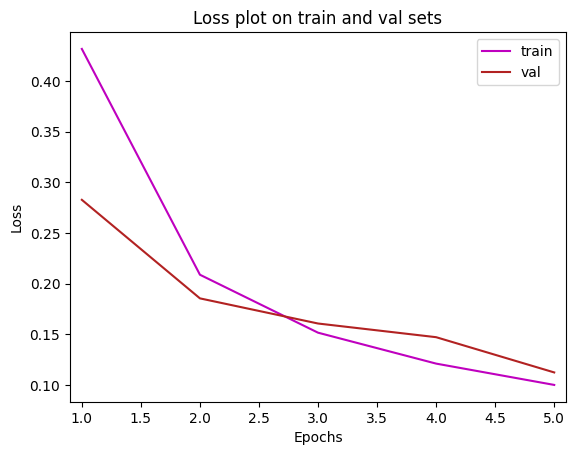

In [ ]:
# plot train and validation loss as a function of #epochs
epochs = np.array([i for i in range(1, len(train_losses)+1)])
loss_train = np.array([l_t for l_t in train_losses])
loss_dev = np.array([l_d for l_d in val_losses])

plt.xlim(0.9, len(train_losses) + 0.1)
plt.plot(epochs, loss_train, linestyle='-', label='train', color='m')
plt.plot(epochs, loss_dev, linestyle='-', label='val', color='firebrick')

plt.title(f"Loss plot on train and val sets")
# Axis labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Show legend
plt.legend()
# Show plot
plt.show()

With the network trained, we can check out it's predictions:

Calculate the model's accuracy on the validation-set.

In [ ]:
def evaluate_model(model, val_loader, is_image_input=False):
  '''
  Evaluate a model on the given dataloader.
  Params:
  model - a pytorch model to train
  val_loader - dataloader for the valset
  is_image_input (default False) - If false, flatten 2d images into a 1d array.
                                   Should be True for Neural Networks
                                   but False for Convolutional Neural Networks.
  '''
  validation_accuracy = 0
  with torch.no_grad():
      for images, labels in val_loader:
          if is_image_input:
            # flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
          # forward pass
          log_ps = model(images)
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim=1)
          # count correct predictions
          equals = top_class == labels.view(*top_class.shape)

          validation_accuracy += torch.sum(equals.type(torch.FloatTensor))
  res = validation_accuracy/len(val_loader.dataset)
  return res

In [ ]:
print(f"Validation accuracy: {evaluate_model(model, val_loader, is_image_input=True)}")

Validation accuracy: 0.9668333530426025


In [ ]:
print(f"Validation accuracy: {evaluate_model(model, val_loader, is_image_input=True)}")

Validation accuracy: 0.9643333554267883


In [ ]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x) # conv 1
        x = F.max_pool2d(x, 2) # max pooling 1
        x = F.relu(x) # relu
        x = self.conv2(x) # conv 2
        x = F.max_pool2d((x), 2) # max pooling 2
        x = F.relu(x) # relu
        x = x.view(-1, 320) # flatten input
        x = self.fc1(x) # hidden layer 1
        x = F.relu(x) # relu
        x = self.fc2(x) # hidden layer 2
        return F.log_softmax(x, dim=1) #output

cnn_model = ConvolutionalNet()
print(cnn_model)

ConvolutionalNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


We can now train the model on the train set.

In [ ]:
# set hyperparameters
cnn_nepochs = 5
cnn_learning_rate = 0.01

In [ ]:
# train the conv model
cnn_model = ConvolutionalNet()
# create sgd optimizer
cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=cnn_learning_rate)
# create negative log likelihood loos
cnn_criterion = nn.NLLLoss()
st = time.time()


train_losses, val_losses = train_model(cnn_model, cnn_optimizer, cnn_criterion,
                                       cnn_nepochs, train_loader, val_loader, is_image_input=False)
en = time.time()
print(st-en)

Epoch: 1/5..  Training Loss: 1.238..  Validation Loss: 0.345.. 
Epoch: 2/5..  Training Loss: 0.246..  Validation Loss: 0.192.. 
Epoch: 3/5..  Training Loss: 0.162..  Validation Loss: 0.135.. 
Epoch: 4/5..  Training Loss: 0.126..  Validation Loss: 0.123.. 
Epoch: 5/5..  Training Loss: 0.105..  Validation Loss: 0.099.. 
-130.52673053741455


In [ ]:
# evaluate on the validation set
print(f"Validation accuracy: {evaluate_model(cnn_model, val_loader, is_image_input=False)}")

Validation accuracy: 0.9694166779518127


You should probably see that our CNN performs better on the validation set compared to the simple neural network (within 3 epochs only!) :)
HAHAHAHAHAHAH VICTORYYYYYYYYYYYYYYY AND LESS TIME CONSUMED!!!!

___________

In [ ]:
## Prepocess

def get_l1_size(lst_kernel_size, maxpool_size, n_output_chanels, image_size = 28):
  for i in range(len(lst_kernel_size)):
    image_size = (image_size - lst_kernel_size[i] + 1) / maxpool_size
  l1_size = n_output_chanels * image_size ** 2
  return int(l1_size)

def reverse_norm(normed_samples, mean, std):
   original_samples = normed_samples * std + mean
   return original_samples

In [ ]:
## Find network and hyperparams that achieve best validation accuracy as possible

# Hyperparameters
cnn_nepochs = 5
cnn_learning_rate = 1e-2
weight_decay = 1e-5
dropout_rate = 0.2
maxpool_size = 2
n_k1 = 40
size_k1 = 5
n_k2 = 40
size_k2 = 7


# Net
class DanConv(nn.Module):
    def __init__(self):
        super(DanConv, self).__init__()

        self.conv1 = nn.Conv2d(1, n_k1, kernel_size = size_k1)
        self.bn_conv1 = nn.BatchNorm2d(n_k1)
        self.drop_conv1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv2d(n_k1, n_k2, kernel_size = size_k2)
        self.bn_conv2 = nn.BatchNorm2d(n_k2)
        self.drop_conv2 = nn.Dropout(dropout_rate)

        self.input_fc1_size = get_l1_size([size_k1, size_k2], maxpool_size, n_k2)
        self.h1 = self.input_fc1_size // 2
        self.fc1 = nn.Linear(self.input_fc1_size, self.h1)
        self.bn_fc1 = nn.BatchNorm1d(self.h1)
        self.drop_fc1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(self.h1, 10)

    def forward(self, x):
        x = reverse_norm(x, mean = 0.5, std = 0.5) # reverse normalization to original data

        x = self.conv1(x) # conv 1
        x = self.bn_conv1(x) # batch norm after conv 1
        x = F.max_pool2d(x, maxpool_size) # max pooling 1
        x = F.relu(x) # relu
        x = self.drop_conv1(x) # first dropout

        x = self.conv2(x) # conv 2
        x = self.bn_conv2(x) # batch norm after conv 2
        x = F.max_pool2d(x, maxpool_size) # max pooling 2
        x = F.relu(x) # relu
        x = self.drop_conv2(x) # second dropout

        x = x.view(x.shape[0], -1) # flatten input
        x = self.fc1(x) # hidden layer 1
        x = self.bn_fc1(x) # batch norm after fc1
        x = torch.tanh(x) # tanh
        x = self.drop_fc1(x) # third dropout
        x = self.fc2(x) # hidden layer 2
        return F.log_softmax(x, dim=1) #output


cnn_model = DanConv()
print(cnn_model)

# create adam optimizer with l2 regularization of lambda = weight_decay
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=cnn_learning_rate, weight_decay = weight_decay)
# create negative log likelihood loos
cnn_criterion = nn.NLLLoss()
st = time.time()
train_losses, val_losses = train_model(cnn_model, cnn_optimizer, cnn_criterion,
                                       cnn_nepochs, train_loader, val_loader, is_image_input=False)
en = time.time()
print(en-st)

DanConv(
  (conv1): Conv2d(1, 40, kernel_size=(5, 5), stride=(1, 1))
  (bn_conv1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_conv1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(40, 40, kernel_size=(7, 7), stride=(1, 1))
  (bn_conv2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_conv2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=360, out_features=180, bias=True)
  (bn_fc1): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_fc1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=180, out_features=10, bias=True)
)
Epoch: 1/5..  Training Loss: 0.147..  Validation Loss: 0.060.. 
Epoch: 2/5..  Training Loss: 0.078..  Validation Loss: 0.057.. 
Epoch: 3/5..  Training Loss: 0.065..  Validation Loss: 0.054.. 
Epoch: 4/5..  Training Loss: 0.060..  Validation Loss: 0.053.. 
Epoch: 5/5..  Training Loss: 0.059..  Validation Loss: 0.037.. 
367.1517

In [ ]:
# evaluate on the validation set
print(f"Validation accuracy: {evaluate_model(cnn_model, val_loader, is_image_input=False)}")

Validation accuracy: 0.9694166779518127
